In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy.stats import ttest_rel,wilcoxon,ranksums,ttest_ind
from statsmodels.stats.multitest import multipletests
from sklearn.cluster import AgglomerativeClustering
import sys
import subprocess
sys.path.append("../code")
from analysis_utils import *

In [2]:
df = pd.read_table('../data/KMAC-v1-library.csv')
df['seq'] = df['phrase']
#deepaccess_predictions = pd.read_csv('../data/KMAC-DeepAccess-library_DeepAccess-predictions.txt',sep=' ',header=None)
#df['DE.prediction'] = deepaccess_predictions[0]
#df['ESC.prediction'] = deepaccess_predictions[1]
df['kmer'] = [get_kmer(d) for d  in df['description']]
df['control'] = [get_type(c) for c in df['category']]
df['background'] = [get_bg(d) for d in df['description']]
df['kmer'].fillna('None', inplace=True)
df['background'].fillna('None', inplace=True)
df['gc.content'] = [(seq.count('G')+seq.count('C'))/len(seq) for seq in df['seq']]
df.head()

,full.phrase,phrase,category,description,dpni.es1,dpni.es2,dpni.endo1,dpni.endo2,dpni.es3,dpni.es4,...,dpnii.endo2,dpnii.es3,dpnii.es4,dpnii.neuro1,dpnii.neuro2,seq,kmer,control,background,gc.content
0,ATCGAAAGGATGGGAGTACTAAGCTCCGCTGTCTCGCGCACCACTA...,CCGCTGTCTCGCGCACCACTAGGTGGCGCCCTCTTGTGGGCGGAAA...,cat1,16.3110504,1010,1277,427,1094,2174,2203,...,5339,6472,7154,7159,7344,CCGCTGTCTCGCGCACCACTAGGTGGCGCCCTCTTGTGGGCGGAAA...,None,motif,None,0.69
1,ATCGAAAGGATGGGAGTACTAAGCTGAAAACGTTCGCGCACCACTA...,GAAAACGTTCGCGCACCACTAGGTGGCGCCCTCTTGTGGGCGGAAA...,cat1,15.53072216,2274,2700,2196,2603,1812,1701,...,17333,6583,6040,6030,6881,GAAAACGTTCGCGCACCACTAGGTGGCGCCCTCTTGTGGGCGGAAA...,None,motif,None,0.66
2,ATCGAAAGGATGGGAGTACTAAGCTTTCCGCTGTCTCGCGCACCAC...,TTCCGCTGTCTCGCGCACCACTAGGTGGCGCCCTCTTGTGGGCGGA...,cat1,15.0963833,882,1087,725,969,2054,1996,...,5336,8117,7421,11254,9491,TTCCGCTGTCTCGCGCACCACTAGGTGGCGCCCTCTTGTGGGCGGA...,None,motif,None,0.67
3,ATCGAAAGGATGGGAGTACTAAGCTCCACTAGGTGGCGCTAGGCGG...,CCACTAGGTGGCGCTAGGCGGAAACGCCGCACTTCCGGCAACAACC...,cat1,14.30055153,691,851,432,741,1751,1921,...,2777,7111,7143,8141,10420,CCACTAGGTGGCGCTAGGCGGAAACGCCGCACTTCCGGCAACAACC...,None,motif,None,0.66
4,ATCGAAAGGATGGGAGTACTAAGCTGCACCACTAGGTGGCGCTAGG...,GCACCACTAGGTGGCGCTAGGCCACGCCCTCTTGTGGGCGGAAACG...,cat1,13.70067341,3369,3810,1696,2883,3571,4022,...,12711,14077,14578,14151,14255,GCACCACTAGGTGGCGCTAGGCCACGCCCTCTTGTGGGCGGAAACG...,None,motif,None,0.68


In [3]:
norm = df.copy()
for i in range(1,5):
        norm['dpnii.es'+str(i)] = norm['dpnii.es'+str(i)]/np.sum(norm['dpnii.es'+str(i)]/1000000)
        norm['dpni.es'+str(i)] = norm['dpni.es'+str(i)]/np.sum(norm['dpni.es'+str(i)]/1000000)
        norm['es'+str(i)] = norm['dpnii.es'+str(i)]/(norm['dpnii.es'+str(i)] + norm['dpni.es'+str(i)])
for i in range(1,3):
        norm['dpnii.endo'+str(i)] = norm['dpnii.endo'+str(i)]/np.sum(norm['dpnii.endo'+str(i)]/1000000)
        norm['dpni.endo'+str(i)] = norm['dpni.endo'+str(i)]/np.sum(norm['dpni.endo'+str(i)]/1000000)
        norm['ed'+str(i)] = norm['dpnii.endo'+str(i)]/(norm['dpnii.endo'+str(i)] + norm['dpni.endo'+str(i)])

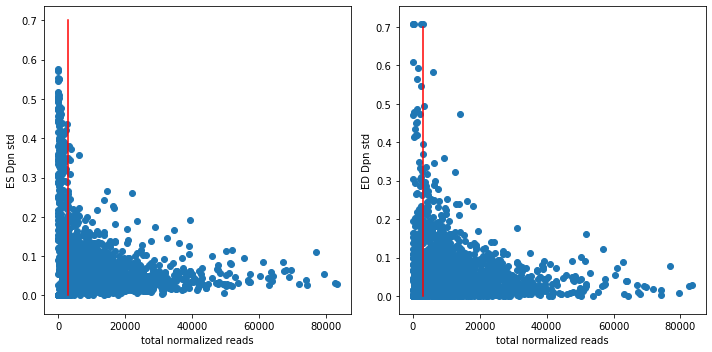

In [4]:
norm['ES Dpn std'] = norm[[c for c in norm.columns if c[:2] == 'es']].std(axis=1)
norm['ED Dpn std'] = norm[[c for c in norm.columns if c[:2] == 'ed']].std(axis=1)

plt.figure(figsize=(10,5))
norm['total normalized reads'] = norm[[c for c in norm.columns if 'dpni' in c or 'dpnii' in c]].sum(axis=1)
plt.subplot(1,2,1)
plt.scatter(x='total normalized reads',y='ES Dpn std',data=norm)
plt.plot([3000,3000],[0.0,0.7],color='r')
plt.xlabel('total normalized reads')
plt.ylabel('ES Dpn std')
plt.tight_layout()
plt.subplot(1,2,2)
norm['total_reads'] = norm[[c for c in norm.columns if 'dpni' in c or 'dpnii' in c]].sum(axis=1)
plt.scatter(x='total normalized reads',y='ED Dpn std',data=norm)
plt.plot([3000,3000],[0.0,0.7],color='r')
plt.xlabel('total normalized reads')
plt.ylabel('ED Dpn std')
plt.tight_layout()
plt.savefig('plots/threshold_KMAC-2K_library.svg')

In [5]:
norm = norm[norm['total normalized reads'] > 3000]
# TODO edit so phrases without controls are not N/As
norm.dropna(inplace=True)
len(norm)

1589

In [6]:
norm['ED Dpn ratio'] = (norm['ed1']+norm['ed2'])/2.0
norm['ES Dpn ratio'] = (norm['es1']+norm['es2']+norm['es3']+norm['es4'])/4.0

In [7]:
from scipy.stats import ranksums
def significance_hist(dist1,dist2,bottom=4.5,test=ranksums):
    top=bottom+0.3
    print(top)
    sig = test(dist1,dist2)
    sstar = "n.s."
    if sig[1] < 0.05:
        sstar = '*'
    if sig[1] < 0.01:
        sstar = '**'
    if sig[1] < 0.001:
        sstar = '***'
    mean1 = np.median(dist1)
    mean2  = np.median(dist2)
    middle = (mean2-mean1)/2.0+mean1
    plt.plot([mean1,mean1],[bottom,top],color='k')
    plt.plot([mean2,mean2],[bottom,top],color='k')
    plt.plot([mean1,mean2],[top,top],color='k')
    plt.text(x=middle,y=top+0.1,s=sstar,ha='center')

In [8]:
native_endo_genome = norm[norm['category'].isin(['cat11','cat13'])]
native_endo_genome.head()

,full.phrase,phrase,category,description,dpni.es1,dpni.es2,dpni.endo1,dpni.endo2,dpni.es3,dpni.es4,...,es3,es4,ed1,ed2,ES Dpn std,ED Dpn std,total normalized reads,total_reads,ED Dpn ratio,ES Dpn ratio
1700,ATCGAAAGGATGGGAGTACTAAGCTATGCTCTGATTTGTTTGTGAA...,ATGCTCTGATTTGTTTGTGAAGTTGGGGTTTGGTTCTAAGAAATCC...,cat11,"141.6094|m1:10.8448,m2:0,m3:0,m4:1.7000,m5:6.3...",482.624322,495.609119,389.898490,345.979053,618.929977,636.399357,...,0.145790,0.183537,0.422315,0.500497,0.092915,0.055283,9362.353400,9362.353400,0.461406,0.243999
1702,ATCGAAAGGATGGGAGTACTAAGCTtcctttgcctcagttccacgt...,TCCTTTGCCTCAGTTCCACGTTTACCTAACATCAACATAAAATAAA...,cat11,"138.8996|m1:10.8448,m2:0,m3:0,m4:1.0499,m5:6.3...",262.210846,248.804578,274.794268,166.736893,448.789672,450.114998,...,0.365561,0.436667,0.362614,0.512773,0.050786,0.106179,7751.875131,7751.875131,0.437694,0.436397
1703,ATCGAAAGGATGGGAGTACTAAGCTAGGAAGGTTTGGAGAGTGAGC...,AGGAAGGTTTGGAGAGTGAGCTGCACTGGGGACATGAATCCCTCTA...,cat11,"128.7659|m1:10.8448,m2:1.7930,m3:0,m4:5.2551,m...",445.638159,368.406779,251.591441,262.957975,1018.462246,1093.012647,...,0.293674,0.313250,0.319786,0.433779,0.101833,0.080605,25283.148770,25283.148770,0.376783,0.388928
1705,ATCGAAAGGATGGGAGTACTAAGCTGTAAGCATTGCCACATGGCGG...,GTAAGCATTGCCACATGGCGGTGTGTCCCTGGAGTAGGTGAACAGG...,cat11,"116.8754|m1:12.7215,m2:0,m3:0,m4:0,m5:6.3768,m...",562.309957,580.410680,444.038420,452.621191,609.887555,602.175022,...,0.463235,0.456191,0.531575,0.498856,0.043195,0.023136,14619.323050,14619.323050,0.515215,0.492688
1706,ATCGAAAGGATGGGAGTACTAAGCTAAGTCCCAACTGAACCAAGAG...,AAGTCCCAACTGAACCAAGAGGAAAGCAGATTTTACACACCTAAAT...,cat11,"111.3532|m1:12.7215,m2:0,m3:1.7882,m4:0,m5:0,m...",501.568454,587.210805,542.764176,600.947552,121.358819,112.420445,...,0.516127,0.437509,0.535631,0.433717,0.073286,0.072065,5735.859395,5735.859395,0.484674,0.476606


88
94
4.8
RanksumsResult(statistic=7.517459147106226, pvalue=5.585100212700847e-14)


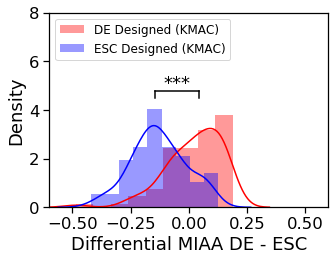

In [12]:
sns.set_context('notebook',font_scale=1.5)

data2cat = {'cat1':'universal open','cat2':'universal close','cat3':'open ED Tatsu',
            'cat4':'open MN Tatsu',
            'cat5':'open ED KMAC','cat6':'open MN KMAC','cat7':'open ESC KMAC',
            'cat8':'opening ED (combinations of KMAC k−mers)',
            'cat9':'opening MN (combinations of KMAC k−mers)',
            'cat10':'opening ESC (combinations of KMAC k−mers)',
            'cat11':'opening ED (native sequences in KMAC peaks)',
            'cat12':'opening MN (native sequences in KMAC peaks)',
            'cat13':'opening ESC (native sequences in KMAC peaks)'}
plt.figure(figsize=(5,4))
norm_keep = norm[norm['category'].isin(['cat5'])]
print(len(norm_keep))
sns.distplot(norm_keep['ED Dpn ratio'] - norm_keep['ES Dpn ratio'],label='DE Designed (KMAC)',color='red')
diff_ED = norm_keep['ED Dpn ratio'] - norm_keep['ES Dpn ratio']
norm_keep = norm[norm['category'].isin(['cat7'])]
print(len(norm_keep))
diff_ES = norm_keep['ED Dpn ratio'] - norm_keep['ES Dpn ratio']
sns.distplot(norm_keep['ED Dpn ratio'] - norm_keep['ES Dpn ratio'],label='ESC Designed (KMAC)',color='blue')
significance_hist(diff_ES,diff_ED)
sig = ranksums(diff_ED,diff_ES)
print(sig)
plt.legend(loc='upper left',fontsize=12)
plt.xlabel('Differential MIAA DE - ESC')
plt.ylabel('Density')
plt.tight_layout()
plt.axis([-0.6,0.6,0,8])

plt.savefig('plots/KMAC-debruijn-library-results.svg')